In [7]:
!wget https://github.com/MNRKhan/aps360-project/raw/master/api/model_blocks.py

--2019-03-30 18:54:14--  https://github.com/MNRKhan/aps360-project/raw/master/api/model_blocks.py
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MNRKhan/aps360-project/master/api/model_blocks.py [following]
--2019-03-30 18:54:15--  https://raw.githubusercontent.com/MNRKhan/aps360-project/master/api/model_blocks.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1293 (1.3K) [text/plain]
Saving to: ‘model_blocks.py’

model_blocks.py     100%[===================>]   1.26K  --.-KB/s    in 0s      

2019-03-30 18:54:15 (179 MB/s) - ‘model_blocks.py’ saved [1293/1293]



In [10]:
!wget https://github.com/MNRKhan/aps360-project/raw/master/trained/model_resnet/full_weights_dc

--2019-03-30 18:56:53--  https://github.com/MNRKhan/aps360-project/raw/master/trained/model_resnet/full_weights_dc
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/MNRKhan/aps360-project/master/trained/model_resnet/full_weights_dc [following]
--2019-03-30 18:56:53--  https://media.githubusercontent.com/media/MNRKhan/aps360-project/master/trained/model_resnet/full_weights_dc
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124218271 (118M) [application/octet-stream]
Saving to: ‘full_weights_dc’

full_weights_dc     100%[===================>] 118.46M  70.3MB/s    in 1.

In [127]:
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/visualizer.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/metrics.py

--2019-03-30 20:39:22--  https://github.com/MNRKhan/aps360-project/raw/master/modules/visualizer.py
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MNRKhan/aps360-project/master/modules/visualizer.py [following]
--2019-03-30 20:39:22--  https://raw.githubusercontent.com/MNRKhan/aps360-project/master/modules/visualizer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3385 (3.3K) [text/plain]
Saving to: ‘visualizer.py.1’

visualizer.py.1     100%[===================>]   3.31K  --.-KB/s    in 0s      

2019-03-30 20:39:22 (55.8 MB/s) - ‘visualizer.py.1’ saved [3385/3385]

--2019-03

In [0]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
#from utils import *
from model_blocks import *
from visualizer import *

encode_out_r = []


def hook_r(module, input, output):
    encode_out_r.append(output)


class extractNet_resnet_prelu(nn.Module):
    def __init__(self, act_type = 'R', r_size = 50):
        super(extractNet_resnet_prelu, self).__init__()

        if r_size == 152:
            resnet = torchvision.models.resnet152(pretrained=True)
        elif r_size == 101:
            resnet = torchvision.models.resnet101(pretrained=True)
        else:
            resnet = torchvision.models.resnet50(pretrained=True)

        # Maxpool output layers
        self.encoder_out_layers = [resnet.conv1,
                                   resnet.maxpool,
                                   resnet.layer1[0].downsample[-1],
                                   resnet.layer2[0].downsample[-1],
                                   resnet.layer3[0].downsample[-1],
                                   resnet.layer4[-1].relu]

        self.res = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze weights
        for param in self.res.parameters():
            param.requires_grad = False

        # Save intermediate output values
        for layer in self.encoder_out_layers:
            layer.register_forward_hook(hook_r)

        self.deconv1 = deconvBlock(2048, 1024, 3, stride=2, padding=1, output_padding=1, act_type = act_type)

        self.deconv2 = deconvBlock(1024 + 1024, 512, 3, stride=2, padding=1, output_padding=1, act_type = act_type)

        self.deconv3 = deconvBlock(512 + 512, 256, 3, stride=2, padding=1, output_padding=1, act_type = act_type)

        self.deconv4 = deconvBlock(256 + 256, 64, 3, stride=1, padding=1, act_type = act_type)

        self.deconv5 = deconvBlock(64 + 64, 64, 3, stride=2, padding=1, output_padding=1, act_type = act_type)

        self.deconv6 = deconvBlock(64 + 64, 3, 3, stride=2, padding=1, output_padding=1, act_type = act_type)

        self.deconv7 = deconvBlock(3, 1, 3, stride=1, padding=1,
                                   with_activation=False, act_type = act_type)

    def forward(self, img):
        global encode_out_r
        encode_out_r = []

        out_res = self.res(img)

        out = self.deconv1(encode_out_r[-1])

        # print(out.shape)

        out = torch.cat((out, encode_out_r[-4]), 1)
        out = self.deconv2(out)

        # print(out.shape)

        out = torch.cat((out, encode_out_r[-5]), 1)
        out = self.deconv3(out)

        # print(out.shape)

        out = torch.cat((out, encode_out_r[-6]), 1)
        out = self.deconv4(out)

        # print(out.shape)

        out = torch.cat((out, encode_out_r[-7]), 1)
        out = self.deconv5(out)

        # print(out.shape)

        out = torch.cat((out, encode_out_r[-8]), 1)
        out = self.deconv6(out)

        # print(out.shape)

        #out = torch.cat((out, img), 1)
        out = self.deconv7(out)

        return out


def extract(in_path, out_path):

    img = get_img(in_path)

    path = "/floyd/input/weights/resnet"

    net = extractNet_resnet_prelu()
    net = load_state_from_dc(net, path)

    transform = transforms.Compose([transforms.ToTensor()])

    input = transform(img).unsqueeze(0)

    out = net(input)

    out = out.squeeze(0).squeeze(0).detach().numpy()

    get_masked(img, out, out_path)


# Both are numpy arrays

def get_masked(original, mask, out_path):

    mask = torch.sigmoid(torch.Tensor(mask))
    mask = thresholdProbMask(mask.squeeze(0).squeeze(0).detach().numpy())
    mask = np.expand_dims(mask, axis=-1)
    
    final = mask * original
    final = np.dstack((final, 255*mask))
    final = final.astype(int)

    
    save_img(out_path, final)


def thresholdProbMask(prob_mask, threshold=0.5):

    prob_mask[prob_mask > threshold] = 1
    prob_mask[prob_mask <= threshold] = 0

    return prob_mask

In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.misc

def save_img(out_path, img):
    scipy.misc.imsave(out_path, img, format = 'png')
    #scipy.misc.toimage(img_, cmin=0.0, cmax=255).save(out_path)
 
def get_img(src):

    img = plt.imread(src)

    height = img.shape[0]
    width = img.shape[1]

    height = height - height % 32
    width = width - width % 32

    img = scipy.misc.imresize(img, [height, width])

    return img

# saves only the deconv weights from the
# given state dictionary
def get_dc_state(state):
    my_state = {name: param for name, param in state.items() if "deconv" in name}
    return my_state


# given a model with pretrained and decoder states
# update the decoder ones with the dc_state dictionary
def update_dc_state(model_state, dc_state):
    for name, param in dc_state.items():
        model_state[name] = param
    return model_state


# given model
# and dc states
# updates only the dc states (not pretrained)
def load_state_from_dc(model, dc_path):
    dc_state = torch.load(dc_path, map_location='cpu')
    new_model_dict = update_dc_state(model.state_dict(), dc_state)

    model.load_state_dict(new_model_dict)

    return model

In [0]:
import matplotlib.pyplot as plt
#import scipy.ndimage as ndimage

def extractTest(in_path, out_path):
    img = get_img(in_path)

    path = "full_weights_dc"

    net = extractNet_resnet_prelu()
    net = load_state_from_dc(net, path)
    
    net = net.eval()
    
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

    input = transform(img).unsqueeze(0)

    out = net(input)

    out = out.squeeze(0).squeeze(0).detach().numpy()

    get_masked(img, out, out_path)
    
    mask = torch.sigmoid(torch.Tensor(out))
    mask = thresholdProbMask(mask.squeeze(0).squeeze(0).detach().numpy(), threshold= 0.5)
    #mask = ndimage.binary_fill_holes(mask)
    #mask= ndimage.gaussian_filter(mask, sigma=(2, 2))
    
    #mask = cv.blur(mask,(2,2))
    #mask= ndimage.gaussian_filter(mask, sigma=(1, 1))
    #mask = thresholdProbMask(mask, threshold= 0.115)
    #mask = ndimage.binary_fill_holes(mask, structure = np.ones((7,7)))
    mask = np.array(mask, dtype=np.uint8)
    mask = denoise(mask, kernel_size = 17)
    #mask= ndimage.gaussian_filter(mask, sigma=(1, 1))
    

    mask = np.expand_dims(mask, axis=-1)

    final = mask * img
    #final = np.dstack((final, 255*mask))
    final = final.astype(int)
   
    show_all(img, final)

def show_all(img, out):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    
    plt.figure()
    plt.imshow(out)
    plt.axis('off')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


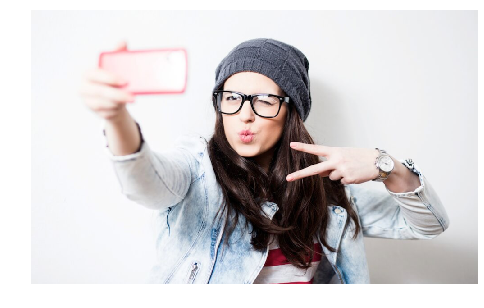

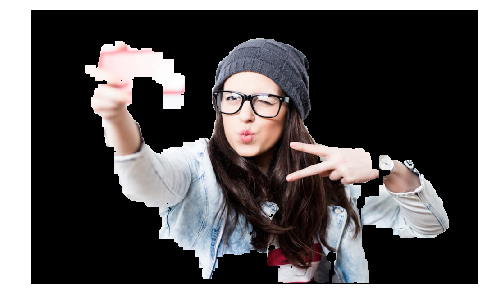

In [417]:
extractTest("download.jpg", "output.png")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


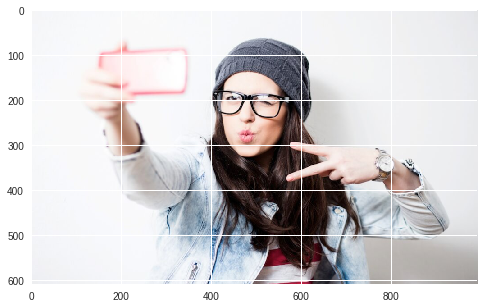

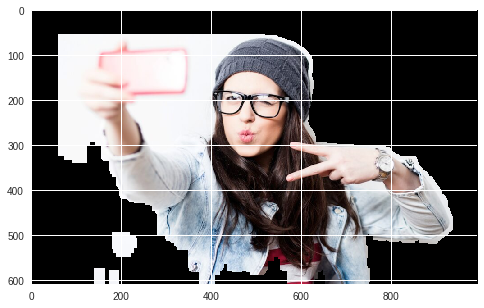

In [282]:

extractTest("download.jpg", "output.png")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


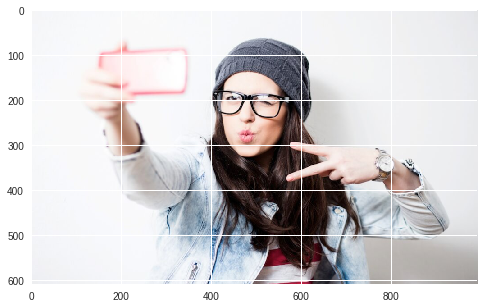

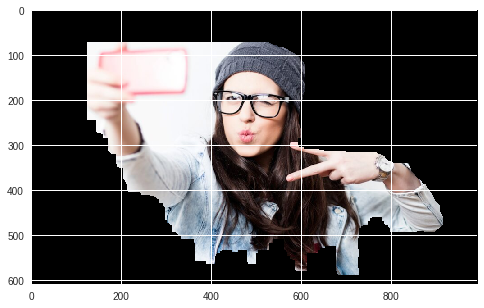

In [223]:
extractTest("download.jpg", "output.png")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


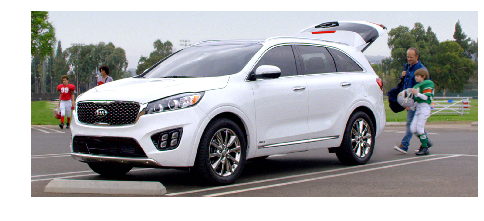

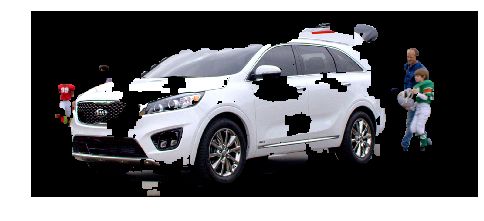

In [418]:
extractTest("download2.jpg", "out2.png")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


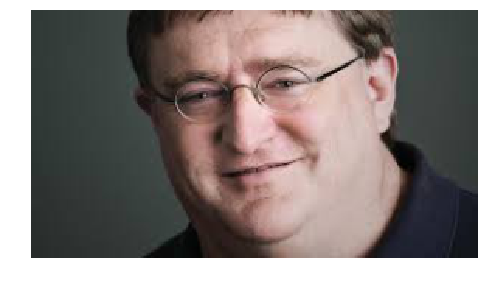

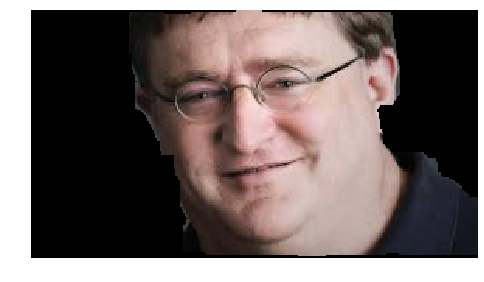

In [413]:
extractTest("download3.jpg", "out3.png")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


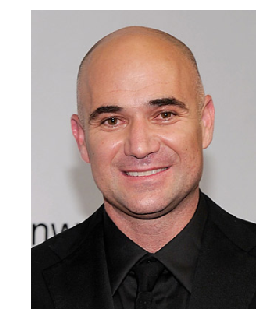

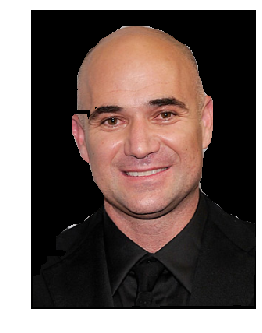

In [419]:
extractTest("doanload4.jpg", "out4.png")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


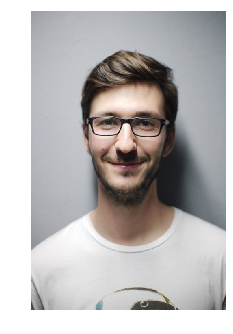

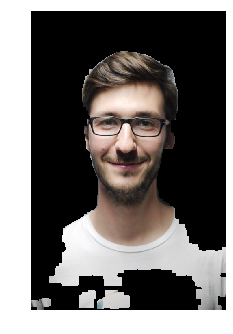

In [420]:
extractTest("download5.jpeg", "out5.png")